In [1]:
import zipfile
import os
import pandas as pd
import cv2
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


In [3]:
from google.colab import drive
drive.mount('/content/drive')

zip_file_path = '/content/drive/MyDrive/export-20241112T162103Z-001.zip'


Mounted at /content/drive


In [4]:
zip_file_path = '/content/export-20241112T162103Z-001.zip'
extracted_folder_path = '/mnt/data/autonomous_driving_data/'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

In [5]:
print(os.listdir(extracted_folder_path))

['export']


In [6]:
export_folder_path = os.path.join(extracted_folder_path, 'export')
annotations_path = os.path.join(export_folder_path, '_annotations.csv')
annotations_df = pd.read_csv(annotations_path)


In [7]:
IMG_SIZE = 64
images = []
labels = []
annotations_grouped = annotations_df.groupby("filename")

In [8]:
for filename, group in annotations_grouped:
    image_path = os.path.join(export_folder_path, filename)
    image = cv2.imread(image_path)
    if image is None:
        continue
    image_resized = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    images.append(image_resized)
    object_labels = group["class"].unique()
    label = " ".join(sorted(object_labels))
    labels.append(label)

In [9]:
images = np.array(images) / 255.0
labels = np.array(labels)

In [10]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)


In [11]:
X_train, X_test, y_train, y_test = train_test_split(images, encoded_labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [12]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)


In [13]:
pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train_flat)
X_val_pca = pca.transform(X_val_flat)
X_test_pca = pca.transform(X_test_flat)

In [14]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    return accuracy, precision, recall, f1, y_pred

In [18]:
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

In [19]:
rf_model = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(rf_model, rf_params, cv=3, scoring='accuracy', n_jobs=-1)
rf_grid.fit(X_train_pca, y_train)
best_rf_model = rf_grid.best_estimator_
accuracy_rf, precision_rf, recall_rf, f1_rf, y_pred_rf = evaluate_model(best_rf_model, X_test_pca, y_test)


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [22]:
knn_params = {
    'n_neighbors': [3, 5, 7, 10],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

In [23]:
knn_model = KNeighborsClassifier()
knn_grid = GridSearchCV(knn_model, knn_params, cv=3, scoring='accuracy', n_jobs=-1)
knn_grid.fit(X_train_pca, y_train)
best_knn_model = knn_grid.best_estimator_
accuracy_knn, precision_knn, recall_knn, f1_knn, y_pred_knn = evaluate_model(best_knn_model, X_test_pca, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [24]:
svm_params = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

In [25]:
svm_model = SVC()
svm_grid = GridSearchCV(svm_model, svm_params, cv=3, scoring='accuracy', n_jobs=-1)
svm_grid.fit(X_train_pca, y_train)
best_svm_model = svm_grid.best_estimator_
accuracy_svm, precision_svm, recall_svm, f1_svm, y_pred_svm = evaluate_model(best_svm_model, X_test_pca, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [26]:
print("Best Random Forest - Accuracy:", accuracy_rf, "Precision:", precision_rf, "Recall:", recall_rf, "F1 Score:", f1_rf)
print("Best k-NN - Accuracy:", accuracy_knn, "Precision:", precision_knn, "Recall:", recall_knn, "F1 Score:", f1_knn)
print("Best SVM - Accuracy:", accuracy_svm, "Precision:", precision_svm, "Recall:", recall_svm, "F1 Score:", f1_svm)

Best Random Forest - Accuracy: 0.8970588235294118 Precision: 0.909137329174094 Recall: 0.8970588235294118 F1 Score: 0.8917815990520055
Best k-NN - Accuracy: 0.8823529411764706 Precision: 0.9084667925141071 Recall: 0.8823529411764706 F1 Score: 0.8897372321327299
Best SVM - Accuracy: 0.8676470588235294 Precision: 0.9061252946926571 Recall: 0.8676470588235294 F1 Score: 0.8749118902674722


In [27]:
plt.figure(figsize=(10, 5))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
rf_metrics = [accuracy_rf, precision_rf, recall_rf, f1_rf]
knn_metrics = [accuracy_knn, precision_knn, recall_knn, f1_knn]
svm_metrics = [accuracy_svm, precision_svm, recall_svm, f1_svm]


<Figure size 1000x500 with 0 Axes>

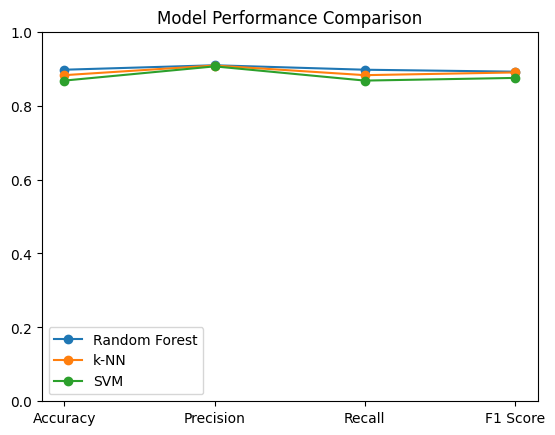

In [28]:
plt.plot(metrics, rf_metrics, label='Random Forest', marker='o')
plt.plot(metrics, knn_metrics, label='k-NN', marker='o')
plt.plot(metrics, svm_metrics, label='SVM', marker='o')
plt.ylim(0, 1)
plt.legend()
plt.title("Model Performance Comparison")
plt.show()

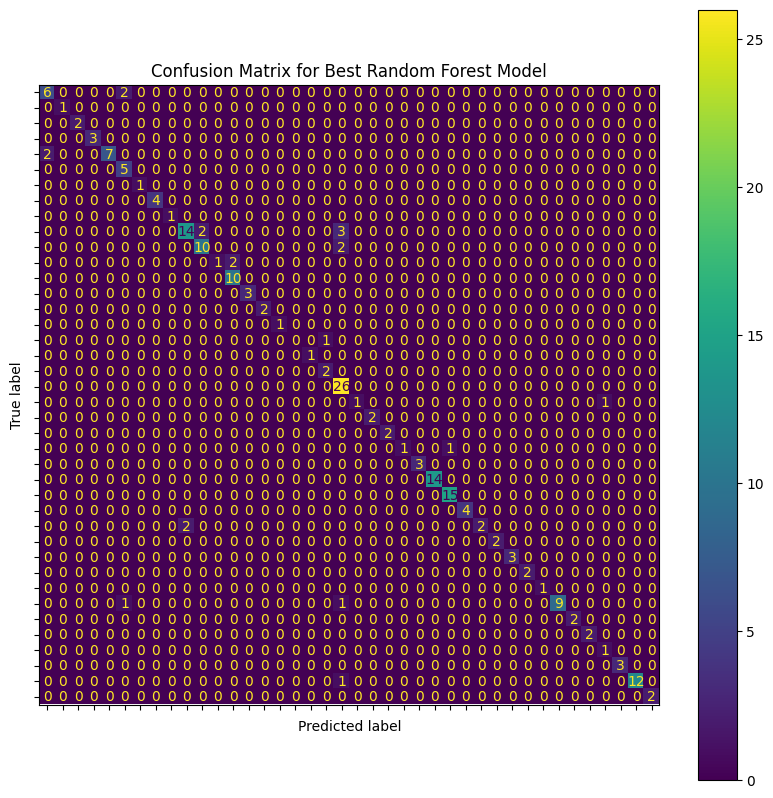

In [30]:
# import the necessary module for handling numerical operations
import numpy as np

cm = confusion_matrix(y_test, y_pred_rf)
# Get the unique labels from y_test and y_pred_rf
unique_labels = np.unique(np.concatenate((y_test, y_pred_rf)))
# Filter label_encoder.classes_ to only include labels present in the data
display_labels = [label for label in label_encoder.classes_ if label in unique_labels]

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax)
plt.title("Confusion Matrix for Best Random Forest Model")
plt.show()

In [31]:
sample_index = 0
sample_image = X_test[sample_index]
sample_image_flat = X_test_pca[sample_index].reshape(1, -1)


In [32]:
predicted_class = best_rf_model.predict(sample_image_flat)
predicted_label = label_encoder.inverse_transform(predicted_class)[0]
true_label = label_encoder.inverse_transform([y_test[sample_index]])[0]


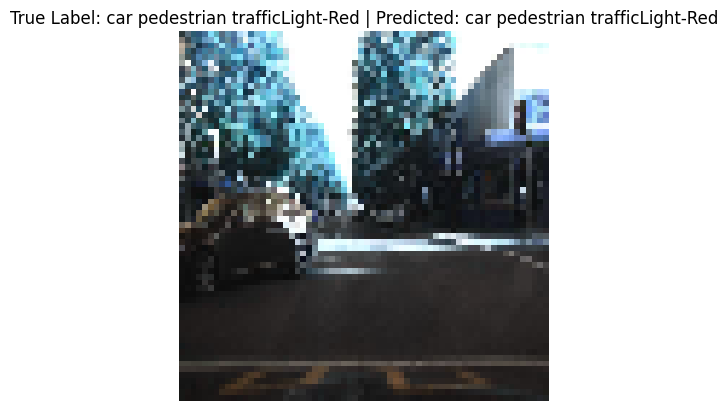

In [33]:
plt.imshow(sample_image)
plt.axis("off")
plt.title(f"True Label: {true_label} | Predicted: {predicted_label}")
plt.show()